# Explore regridding

This notebook is simply for exploring the regridding options via xESMF, to make sure results look OK and to get an understanding of how intensive the process can be, which is useful for calibrating slurm jobs. 

In [1]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe

from config import (
    target_grid_fp,
    cmip6_dir,
    SCRATCH_DIR,
    model_inst_lu,
    transfers_config,
)

# ignore serializationWarnings from xarray for datasets with multiple FillValues
import warnings

warnings.filterwarnings("ignore", category=xr.SerializationWarning)

Open the dataset containing the target grid. 

Shift that grid to the standard -180 to 180 grid prior to regridding.

In [83]:
dst_ds = xr.open_dataset(target_grid_fp)
lon_enc = dst_ds["lon"].encoding
lon_attrs = dst_ds["lon"].attrs
# subtract from 0-360 lon coords to get -180 to 180 lon coords, and reapply encoding
dst_ds.coords["lon"] = (dst_ds.coords["lon"] + 180) % 360 - 180
dst_ds["lon"].encoding = lon_enc
dst_ds["lon"].attrs = lon_attrs
# sort and verify
dst_ds = dst_ds.sortby(dst_ds.lon, ascending=True)

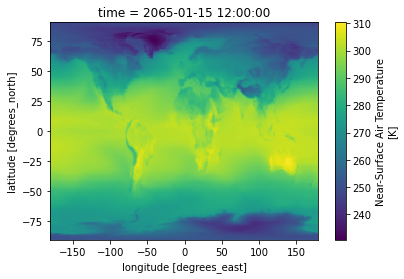

In [3]:
dst_ds.isel(time=0).tas.plot()

Open a dataset to regrid. First, try a monthly file of the same variable as the target:

In [4]:
src_fp = cmip6_dir.joinpath(
    "/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Amon/tas/gn/v20200702/tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc"
)
src_ds = xr.open_dataset(src_fp)

Now regrid:

In [5]:
%%time
regridder = xe.Regridder(src_ds, dst_ds, 'bilinear', unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

CPU times: user 3.63 s, sys: 389 ms, total: 4.02 s
Wall time: 4.17 s


View the results (original on the left):

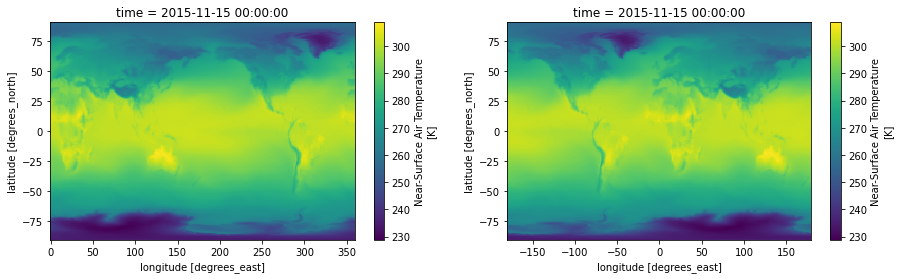

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds["tas"].isel(time=10).plot(ax=ax[0])
regrid_ds["tas"].isel(time=10).plot(ax=ax[1])

Note, this does cause a line at the prime meridian for some datasets, but that might be the case with the other proposed solution as well.

For example, GFDL-ESM4 does not have data at 0 degrees longitude:

Minimum longitude: 0.625
Maximum longitude: 359.375


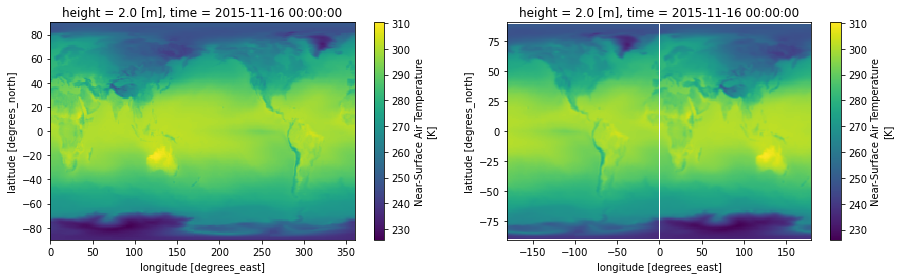

In [7]:
src_fp = cmip6_dir.joinpath(
    "ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-ESM4_ssp585_r1i1p1f1_gr1_201501-210012.nc"
)
src_ds = xr.open_dataset(src_fp)
print(f"Minimum longitude: {src_ds.lon.min()}")
print(f"Maximum longitude: {src_ds.lon.max()}")

regridder = xe.Regridder(src_ds.isel(time=10), dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds.isel(time=10), keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds["tas"].isel(time=10).plot(ax=ax[0])
regrid_ds["tas"].plot(ax=ax[1])

What if we use the periodic argument to specify it is periodic in longitude?

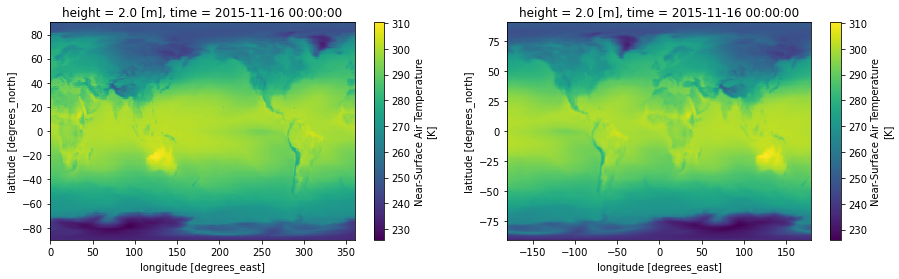

In [8]:
regridder = xe.Regridder(
    src_ds.isel(time=10), dst_ds, "bilinear", unmapped_to_nan=True, periodic=True
)
regrid_ds = regridder(src_ds.isel(time=10), keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds["tas"].isel(time=10).plot(ax=ax[0])
regrid_ds["tas"].plot(ax=ax[1])

That appears to work well, and is probably a technically better solution than extrapolation, although that does give a similar result:

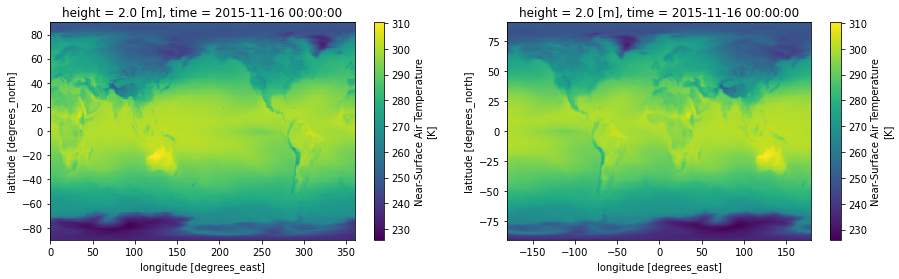

In [9]:
regridder = xe.Regridder(
    src_ds, dst_ds, "bilinear", unmapped_to_nan=True, extrap_method="nearest_s2d"
)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds["tas"].isel(time=10).plot(ax=ax[0])
regrid_ds["tas"].isel(time=10).plot(ax=ax[1])

So what would this look like, for all models? How many pixels would we be interpolating for each?

Define a function to take a model and scenario and figure out what pixels are extrapolated:

In [10]:
def get_interp_pixel_mask(model):

    scenario = "ssp585"

    inst = model_inst_lu[model]
    variant = transfers_config.prod_variant_lu[model]

    try:
        src_fp = list(
            cmip6_dir.glob(
                f"ScenarioMIP/{inst}/{model}/{scenario}/{variant}/Amon/tas/*/*/tas_Amon_{model}_{scenario}_{variant}_*.nc"
            )
        )[0]
    except IndexError:
        print(f"No files found for {model}, {scenario}")
        return None

    src_ds = xr.open_dataset(src_fp)

    # we only need the non-extrapolated version, expect all NaNs to be filled
    try:
        regridder = xe.Regridder(
            src_ds["tas"].isel(time=0), dst_ds, "bilinear", unmapped_to_nan=True
        )
        non_extrap_ds = regridder(src_ds["tas"].isel(time=0), keep_attrs=True)
    except KeyError:
        print(f"tas not found in {src_fp}?")
        return None

    return np.isnan(non_extrap_ds)

In [11]:
interp_masks = {}
for model in transfers_config.prod_variant_lu:
    interp_masks[model] = get_interp_pixel_mask(model)

No files found for MRI-ESM2-0, ssp585


In [12]:
# drop empty models (shouldn't be any but there is a bug currently about MRI- model)
interp_masks = {k: v for k, v in interp_masks.items() if v is not None}
# now cross compare grids to see if any are equal (we assume the NCAR-based grids would all be the same (CESM2, NorESM, TaiESM1..))
done_sets = []
for m1, m2 in product(interp_masks.keys(), interp_masks.keys()):
    if m1 == m2:
        continue
    if {m1, m2} not in done_sets:
        # only need to check if the comparison has not been made
        if np.array_equal(interp_masks[m1], interp_masks[m2]):
            print(f"{m1} and {m2} are the same")
            done_sets.append({m1, m2})

CNRM-CM6-1-HR and EC-Earth3-Veg are the same
CNRM-CM6-1-HR and MPI-ESM1-2-HR are the same
EC-Earth3-Veg and MPI-ESM1-2-HR are the same
GFDL-ESM4 and HadGEM3-GC31-LL are the same
GFDL-ESM4 and HadGEM3-GC31-MM are the same
GFDL-ESM4 and KACE-1-0-G are the same
HadGEM3-GC31-LL and HadGEM3-GC31-MM are the same
HadGEM3-GC31-LL and KACE-1-0-G are the same
HadGEM3-GC31-MM and KACE-1-0-G are the same
NorESM2-MM and TaiESM1 are the same
NorESM2-MM and CESM2-WACCM are the same
TaiESM1 and CESM2-WACCM are the same


Okay it looks like we have three different groups here:
1. CNRM-CM6-1-HR, EC-Earth3-Veg, MPI-ESM1-2-HR
2. GFDL-ESM4, HadGEM3-GC31-LL, HadGEM3-GC31-MM, KACE-1-0-G
3. TaiESM1, NorESM2-MM, CESM2-WACCM

The first case appears to only have 1 single extrapolated rows along the top and bottom:

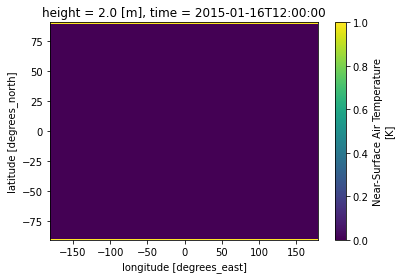

In [13]:
interp_masks["CNRM-CM6-1-HR"].plot()

The second case has the missing prime meridian:

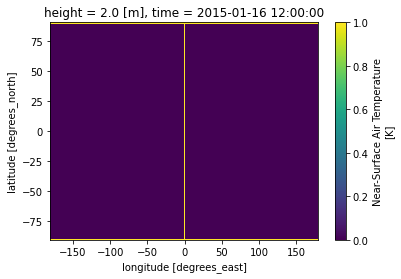

In [14]:
interp_masks["GFDL-ESM4"].plot()

And the third case of course has no extrapolations:

In [15]:
assert np.all(~interp_masks["TaiESM1"])

With this information, it is probably safe to simply have a note for our datasets that the northernmost row of pixels (288 total) were extrapolated for CNRM-CM6-1-HR, EC-Earth3-Veg, and MPI-ESM1-2-HR, and those along the prime meridian were additionally extrapolated for GFDL-ESM4, HadGEM3-GC31-LL, HadGEM3-GC31-MM, and KACE-1-0-G (this will end up being 42 pixels after cropping to the panarctic). 

### How is xESMF handling nodata

It looks like the NaNs are treated as numbers in xESMF, and we will likely need to modify the datasets with masks to achieve the desired regridding.

Here is an example with a data file already on the target grid, and so we would expect values to match exactly, but they clearly don't:

In [16]:
model = "CESM2-WACCM"
scenario = "ssp585"

inst = model_inst_lu[model]
variant = transfers_config.prod_variant_lu[model]
var_id = "mrro"
table_id = "Lmon"

src_fp = list(
    cmip6_dir.glob(
        f"ScenarioMIP/{inst}/{model}/{scenario}/{variant}/{table_id}/{var_id}/*/*/{var_id}_{table_id}_{model}_{scenario}_{variant}_*.nc"
    )
)[0]

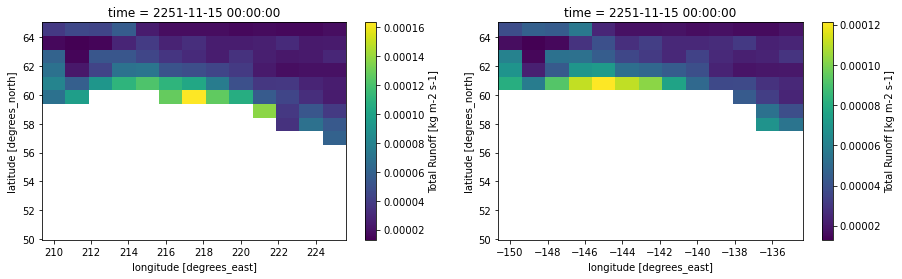

In [17]:
src_ds = xr.open_dataset(src_fp)
# lets just work on one time slice, on a bbox near the coast
src_ds = src_ds.isel(time=[10])
regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[0])
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[1])

Supposedly, you only need to have one dataset with a mask variable. Let's try adding it to the source dataset:

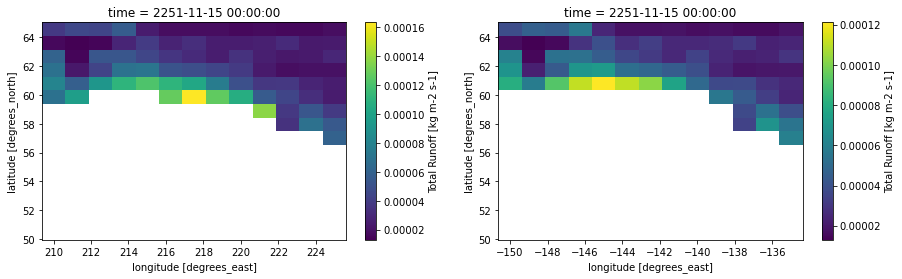

In [22]:
# add mask to the source dataset (to be regridded)
src_ds["mask"] = xr.where(~np.isnan(src_ds[var_id]), 1, 0).isel(time=0)

regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[0])
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[1])

Well that didn't seem to work. 

What if we try a different target dataset? One that has same nodata mask?

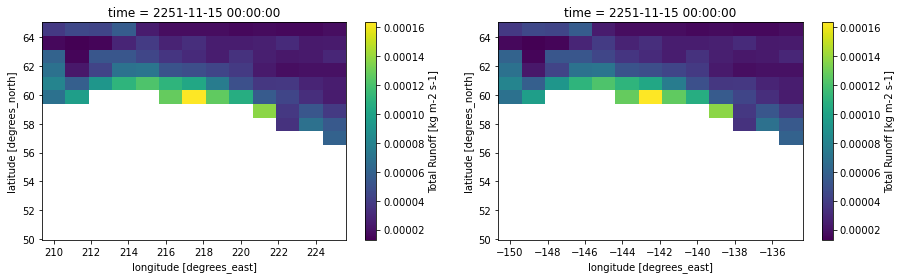

In [43]:
mrro_target_grid_fp = cmip6_dir.joinpath(
    "ScenarioMIP/NCAR/CESM2-WACCM/ssp370/r1i1p1f1/Lmon/mrro/gn/v20190815/mrro_Lmon_CESM2-WACCM_ssp370_r1i1p1f1_gn_201501-206412.nc"
)

# define target grid
mrro_dst_ds = xr.open_dataset(mrro_target_grid_fp).isel(time=0).drop_vars("time")
# check that the nodata pixels are the same on a subsection of the arrays the does not overlap the boundaries
# src ds is on 0-360
assert np.all(np.isnan(src_ds[var_id].isel(time=0)) == np.isnan(mrro_dst_ds[var_id]))


# do the grid shifting for target grid
lon_enc = mrro_dst_ds["lon"].encoding
lon_attrs = mrro_dst_ds["lon"].attrs
mrro_dst_ds.coords["lon"] = (mrro_dst_ds.coords["lon"] + 180) % 360 - 180
mrro_dst_ds["lon"].encoding = lon_enc
mrro_dst_ds["lon"].attrs = lon_attrs
mrro_dst_ds = mrro_dst_ds.sortby(mrro_dst_ds.lon, ascending=True)

regridder = xe.Regridder(src_ds, mrro_dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[0])
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[1])

That seems to work. Note that we ensured the nodata masks are the same prior to shifting the target dataset to [-180, 180]. Double check that the values are the same:

In [41]:
assert np.array_equal(
    src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)),
    regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)),
    equal_nan=True,
)

Yep. So another check, does this work without a `mask` variable in the source dataset?

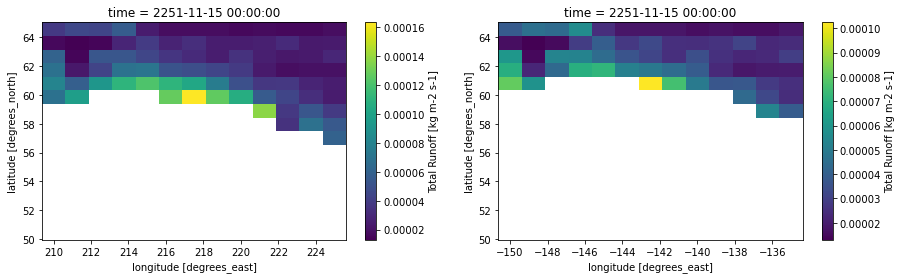

In [28]:
regridder = xe.Regridder(
    src_ds.drop_vars("mask"), dst_ds, "bilinear", unmapped_to_nan=True
)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[0])
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[1])

It does not. So it looks like we will need a `mask` variable in the source dataset regardless. 

What if we put a `mask` variable in the original target dataset?

Well, it turns out that is not as easy as it would seem! Notice what the mask looks like:

In [113]:
xr.where(~np.isnan(mrro_dst_ds[var_id]), 1, 0)

<xarray.DataArray 'mrro' (lat: 192, lon: 288)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8

And how it becomes something else when assigned to the original target dataset:

<xarray.DataArray 'mask' (lat: 192, lon: 288)>
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8


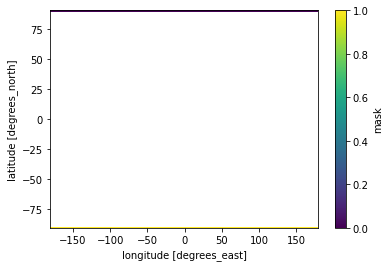

In [115]:
dst_ds["mask"] = xr.where(~np.isnan(mrro_dst_ds[var_id]), 1, 0)
print(dst_ds["mask"])
dst_ds["mask"].plot()

It looks like the latitude values are slightly different, which is causing a conflict in copying the mask data values in for all but those with -90 or 90 latitude:

In [138]:
mask = xr.where(~np.isnan(mrro_dst_ds[var_id]), 1, 0)
mask.lat.values == dst_ds.lat.values

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [140]:
print(mask.lat.values[:5])
print(dst_ds.lat.values[:5])

[-90.         -89.0575943  -88.11518097 -87.17277527 -86.23036957]
[-90.         -89.05759162 -88.11518325 -87.17277487 -86.23036649]


Yeah it looks like these are different in each file too, here are the first few outputs of `ncdump -v lat` on each of the target file sin play here:

```
-90, -89.0575942993164, -88.1151809692383, -87.1727752685547,
-90, -89.0575916230366, -88.1151832460733, -87.1727748691099,
```

However, these are the same down to 5 decimal places, which should correspond to distances of ~1m. So since we have same values here, we can essentially just choose whatever array of latitude values we want to go with here. We will just use the latitude values from the original destination dataset:

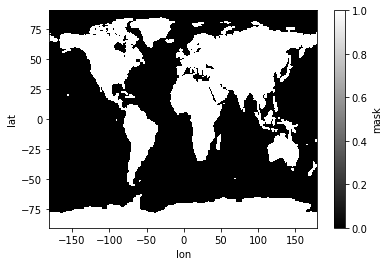

In [153]:
dst_ds["mask"] = (["lat", "lon"], mask.values)
dst_ds["mask"].plot(cmap="binary_r")

There we go. Now let's see if that works for the regridding:

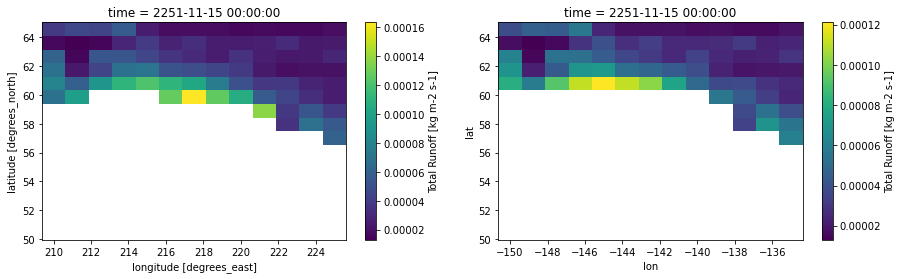

In [154]:
regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds[var_id].sel(lat=slice(50, 65), lon=slice(210, 225)).plot(ax=ax[0])
regrid_ds[var_id].sel(lat=slice(50, 65), lon=slice(-150, -135)).plot(ax=ax[1])

Nope. 

So it looks like we need:

1. add a `mask` variable in the source grid dataset for any that have NaN values
2. a target grid dataset with NaN values in the same places as the mask in the source dataset.


Of course, 2. is not possible for datasets not on the common grid already, so we need to figure out what will work here maybe. Maybe just matching variables is our best bet?

As far as implementing this programmatically, it might be best to first check if there are any NaNs in the dataset to be regridded, and only add the `mask` variable if we find any, and load up the desired target file that has the NaNs we need? We see below that the `mask` variable persists in the regridded output, so we should probably drop that variable before writing the .nc file.

In [158]:
regrid_ds

<xarray.Dataset>
Dimensions:  (time: 1, lat: 192, lon: 288)
Coordinates:
  * time     (time) object 2251-11-15 00:00:00
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
Data variables:
    mrro     (time, lat, lon) float32 3.289e-18 5.006e-18 -7.432e-19 ... nan nan
    mask     (lat, lon) int64 1 1 ... -9223372036854775808 -9223372036854775808
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    branch_method:          standard
    branch_time_in_child:   766500.0
    branch_time_in_parent:  766500.0
    case_id:                1678
    cesm_casename:          b.e21.BWSSP585extcmip6.f09_g17.CMIP6-SSP5-8.5ext-...
    ...                     ...
    parent_activity_id:     CMIP
    parent_experiment_id:   historical
    parent_mip_era:         CMIP6
    parent_source_id:       CESM2-WACCM
    parent_time_units:      days since 0001-01-01 00:00:00
    regrid_method:          bilinear

It is worth checking what things would look like for both options with a dataset that is not already on the target grid. 

In this case, it looks like 0 is the "mask" value, not NaN:

In [200]:
model = "GFDL-ESM4"
scenario = "ssp585"

inst = model_inst_lu[model]
variant = transfers_config.prod_variant_lu[model]
var_id = "mrro"
table_id = "Lmon"

src_fp = list(
    cmip6_dir.glob(
        f"ScenarioMIP/{inst}/{model}/{scenario}/{variant}/{table_id}/{var_id}/*/*/{var_id}_{table_id}_{model}_{scenario}_{variant}_*.nc"
    )
)[0]

src_ds = xr.open_dataset(src_fp)
# lets just work on one time slice, on a bbox near the coast
src_ds = src_ds.isel(time=[10])

src_ds.mrro

<xarray.DataArray 'mrro' (time: 1, lat: 180, lon: 288)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 2015-11-16 00:00:00
Attributes:
    long_name:        Total Runoff
    units:            kg m-2 s-1
    cell_methods:     area: mean where land time: mean
    ocean_fillvalue:  0.0
    cell_measures:    area: areacella
    standard_name:    runoff_flux
    interp_method:    conserve_order1
    original_name:    mrro
    comment:          land_area = areacella * sftlf * 0.01

Notice the "ocean_fillvalue": 0. Great choice!!!!!!@#\$@#$%@

So that is going to complicate things, because it looks like 0 does occur inside the land as well:

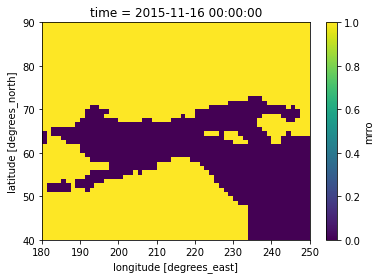

In [201]:
(src_ds.mrro == 0).sel(lat=slice(40, 90), lon=slice(180, 250)).plot()

You can see this propogated in teh regridding. Make the mask:

In [204]:
src_ds["mask"] = xr.where(src_ds[var_id] != 0, 1, 0).isel(time=0)

Including `mask` variable to the source dataset only:

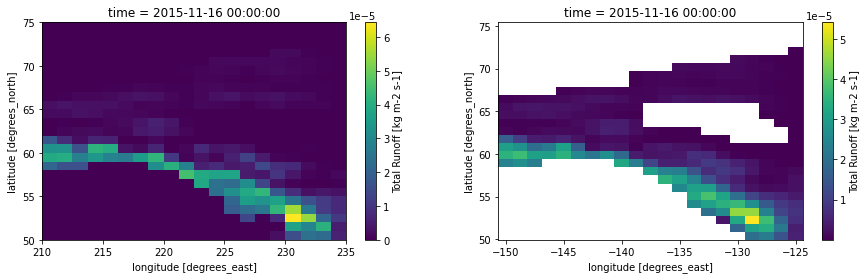

In [207]:
regridder = xe.Regridder(src_ds, mrro_dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds[var_id].sel(lat=slice(50, 75), lon=slice(210, 235)).plot(ax=ax[0])
regrid_ds[var_id].sel(lat=slice(50, 75), lon=slice(-150, -125)).plot(ax=ax[1])

So, yeah.. more work to be done here..

### Test regridding object re-use

Now ensure that we can use the same regridding object on a file with a different number of time steps (e.g. a daily file) but with the same grid. This will help us be more efficient. According to the docs, [this should be acceptable](https://xesmf.readthedocs.io/en/latest/notebooks/Reuse_regridder.html).

In [15]:
daily_src_fp = cmip6_dir.joinpath(
    "ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/day/tas/gr1/v20180701/tas_day_GFDL-ESM4_ssp585_r1i1p1f1_gr1_20150101-20341231.nc"
)
daily_src_ds = xr.open_dataset(daily_src_fp)

Regrid:

In [16]:
%%time
daily_regrid_ds = regridder(daily_src_ds, keep_attrs=True)

CPU times: user 8.6 s, sys: 2.6 s, total: 11.2 s
Wall time: 12.3 s


Plot results:

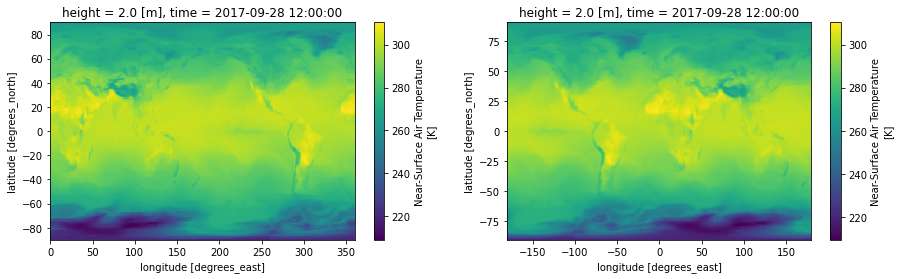

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
daily_src_ds["tas"].isel(time=1000).plot(ax=ax[0])
daily_regrid_ds["tas"].isel(time=1000).plot(ax=ax[1])

Plot the time series at a single point to make sure the broadcasting is correct (top is original):

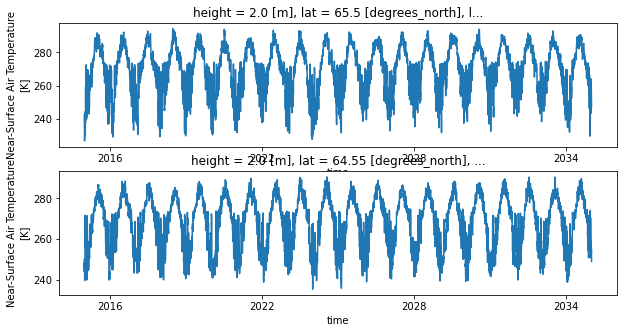

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
test_lon = 180 + (180 - 148)  # lon domain is approx (0, 360)
test_lat = 65
daily_src_ds["tas"].sel(lat=test_lat, lon=test_lon, method="nearest").plot(ax=ax[0])
daily_regrid_ds["tas"].sel(lat=test_lat, lon=test_lon, method="nearest").plot(ax=ax[1])

Great. So we can use an established `regridder` object with weights to regrid multiple files, provided they have the same grid. Also, note that regridding the daily file took approximately 30s.

## Optimizing for multiple files

This section will be used to determine a reasonable number of files to regrid in a single `sbatch` job. We will attempt to regrid a handful of daily files using `dask.delayed`, and compare.

In [11]:
import dask

Choose some daily temperature files to regrid. There should be 20 in this glob:

In [20]:
src_fps = list(
    cmip6_dir.glob(
        "ScenarioMIP/NOAA-GFDL/GFDL-ESM4/*/r1i1p1f1/day/tas/gr1/v20180701/*.nc"
    )
)
len(src_fps)

20

Define a function to regrid and write a file:

In [26]:
@dask.delayed
def regrid_file(fp, regridder, out_fp):
    src_ds = xr.open_dataset(fp)
    regrid_ds = regridder(src_ds)
    regrid_ds.to_netcdf(out_fp)

    return out_fp

Make and output dir:

In [27]:
out_dir = SCRATCH_DIR.joinpath("regrid_testing")
out_dir.mkdir(exist_ok=True)

Create the regridder object:

In [ ]:
daily_regrid_ds = regridder(daily_src_ds, keep_attrs=True)

Run the regridding:

In [30]:
results = []
for fp in src_fps:
    out_fp = out_dir.joinpath(fp.name.replace(".nc", "_regrid.nc"))
    results.append(regrid_file(fp, regridder, out_fp))

In [31]:
%%time
dask.compute(results)

CPU times: user 6min 37s, sys: 5min 27s, total: 12min 5s
Wall time: 6min 34s


([PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20350101-20541231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20750101-20941231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20550101-20741231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20950101-21001231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20150101-20341231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp370_r1i1p1f1_gr1_20350101-20541231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp370_r1i1p1f1_gr1_20750101-20941231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredil

Okay this seems like an efficient and simple way to move forward. If we can process 20 daily files in under 6 minutes, we should be safe with only trying to process ~200 files in under the two hours. This should inform our generation of batch files, with each batch file containing at most 200 hundred files. 